In [ ]:
!pip install torch torchvision opencv-python numpy pandas
!pip install torch torchvision opencv-python numpy pandas pillow


import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import zipfile
import os
import matplotlib.pyplot as plt
from torchvision import transforms, models
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import norm
import logging

from sklearn.metrics import mean_absolute_error


INFO:__main__:Creating dataset...
INFO:__main__:Found 15 .avi files and 15 .txt files
INFO:__main__:Matched: p4v1.avi with p4t1.txt
INFO:__main__:Matched: p4v2.avi with p4t2.txt
INFO:__main__:Matched: p4v12.avi with p4t12.txt
INFO:__main__:Matched: p5v6.avi with p5t6.txt
INFO:__main__:Matched: p5v10.avi with p5t10.txt
INFO:__main__:Matched: p5v11.avi with p5t11.txt
INFO:__main__:Matched: p1v1.avi with p1t1.txt
INFO:__main__:Matched: p1v4.avi with p1t4.txt
INFO:__main__:Matched: p1v9.avi with p1t9.txt
INFO:__main__:Matched: p2v4.avi with p2t4.txt
INFO:__main__:Matched: p2v10.avi with p2t10.txt
INFO:__main__:Matched: p2v13.avi with p2t13.txt
INFO:__main__:Matched: p3v16.avi with p3t16.txt
INFO:__main__:Matched: p3v19.avi with p3t19.txt
INFO:__main__:Matched: p3v21.avi with p3t21.txt
INFO:__main__:Found 15 matched video-annotation pairs
INFO:__main__:Processing pair: p4v1.avi - p4t1.txt
INFO:__main__:Processed 2000 frames from p4v1.avi
INFO:__main__:Processing pair: p4v2.avi - p4t2.txt
IN

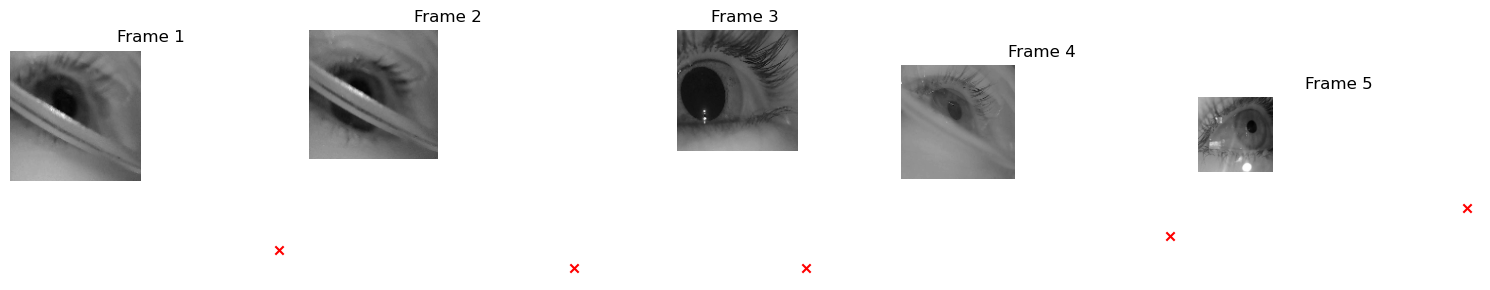

In [25]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class PupilDataset(Dataset):
    def __init__(self, video_zip_path, annotation_zip_path, transform=None, mode='train'):
        """
        Dataset class for loading and preprocessing video and annotation data
        
        Args:
            video_zip_path (str): Path to ZIP file containing .avi videos
            annotation_zip_path (str): Path to ZIP file containing .txt annotations
            transform: Optional transforms to apply to frames
            mode (str): 'train', 'val', or 'test'
        """
        self.transform = transform
        self.mode = mode
        self.frames = []
        self.annotations = []
        self.video_ids = []
        
        # Check if zip files exist
        if not os.path.exists(video_zip_path):
            raise FileNotFoundError(f"Video ZIP file not found: {video_zip_path}")
        if not os.path.exists(annotation_zip_path):
            raise FileNotFoundError(f"Annotation ZIP file not found: {annotation_zip_path}")
            
        # Create temp directory if it doesn't exist
        os.makedirs('temp', exist_ok=True)
        
        try:
            with zipfile.ZipFile(video_zip_path, 'r') as vid_zip, \
                 zipfile.ZipFile(annotation_zip_path, 'r') as ann_zip:
                
                # List all files in the zips
                video_files = [f for f in vid_zip.namelist() if f.endswith('.avi')]
                ann_files = [f for f in ann_zip.namelist() if f.endswith('.txt')]
                
                logger.info(f"Found {len(video_files)} .avi files and {len(ann_files)} .txt files")
                
                if not video_files:
                    raise ValueError(f"No .avi files found in {video_zip_path}")
                if not ann_files:
                    raise ValueError(f"No .txt files found in {annotation_zip_path}")
                
                # Create mapping between video and annotation files
                video_ann_pairs = []
                for video_file in video_files:
                    # Extract participant number and video number
                    # Example: from 'p1v4.avi' extract p_num='1', v_num='4'
                    video_match = os.path.splitext(os.path.basename(video_file))[0]  # e.g., 'p1v4'
                    p_num = video_match[1:].split('v')[0]  # Get '1' from 'p1v4'
                    v_num = video_match.split('v')[1]      # Get '4' from 'p1v4'
                    
                    # Look for matching annotation file (p1t4.txt)
                    expected_ann = f"p{p_num}t{v_num}.txt"
                    ann_file = next((f for f in ann_files if os.path.basename(f) == expected_ann), None)
                    
                    if ann_file:
                        video_ann_pairs.append((video_file, ann_file))
                        logger.info(f"Matched: {video_file} with {ann_file}")
                    else:
                        logger.warning(f"No matching annotation file found for video: {video_file} (looking for {expected_ann})")
                
                logger.info(f"Found {len(video_ann_pairs)} matched video-annotation pairs")
                
                # Rest of the code remains the same...
                video_id = 0
                for video_file, ann_file in video_ann_pairs:
                    logger.info(f"Processing pair: {video_file} - {ann_file}")
                    
                    # Load annotations first
                    annotations = []
                    with ann_zip.open(ann_file) as f:
                        lines = f.readlines()
                        for line in lines:
                            try:
                                data = line.decode().strip().split()
                                if len(data) >= 2:
                                    annotations.append({
                                        'x': float(data[0]),
                                        'y': float(data[1])
                                    })
                            except Exception as e:
                                logger.error(f"Error parsing annotation line in {ann_file}: {str(e)}")
                                continue
                    
                    if not annotations:
                        logger.warning(f"No valid annotations found in {ann_file}, skipping video")
                        continue
                    
                    # Extract and process video
                    vid_zip.extract(video_file, 'temp')
                    video_path = os.path.join('temp', video_file)
                    
                    # Process video frames
                    cap = cv2.VideoCapture(video_path)
                    if not cap.isOpened():
                        logger.error(f"Could not open video: {video_file}")
                        continue
                    
                    frame_idx = 0
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                            
                        if frame_idx < len(annotations):
                            try:
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                resized = cv2.resize(gray, (128, 128))
                                
                                self.frames.append(resized)
                                self.annotations.append(annotations[frame_idx])
                                self.video_ids.append(video_id)
                                
                            except Exception as e:
                                logger.error(f"Error processing frame {frame_idx} in {video_file}: {str(e)}")
                        
                        frame_idx += 1
                    
                    cap.release()
                    logger.info(f"Processed {frame_idx} frames from {video_file}")
                    
                    # Clean up extracted video file
                    try:
                        os.remove(video_path)
                    except Exception as e:
                        logger.error(f"Error removing temporary file {video_file}: {str(e)}")
                    
                    video_id += 1
                
                logger.info(f"Final dataset size: {len(self.frames)} frames from {video_id} videos")
                
                if len(self.frames) == 0:
                    raise ValueError("No frames were successfully processed")
                
                if len(self.frames) != len(self.annotations):
                    raise ValueError(f"Mismatch between frames ({len(self.frames)}) and annotations ({len(self.annotations)})")
              
                video_id = 0
                for video_file, ann_file in video_ann_pairs:
                    logger.info(f"Processing pair: {video_file} - {ann_file}")
                    
                    # Load annotations first
                    annotations = []
                    with ann_zip.open(ann_file) as f:
                        lines = f.readlines()
                        for line in lines:
                            try:
                                data = line.decode().strip().split()
                                if len(data) >= 2:
                                    annotations.append({
                                        'x': float(data[0]),
                                        'y': float(data[1])
                                    })
                            except Exception as e:
                                logger.error(f"Error parsing annotation line in {ann_file}: {str(e)}")
                                continue
                    
                    if not annotations:
                        logger.warning(f"No valid annotations found in {ann_file}, skipping video")
                        continue
                    
                    # Extract and process video
                    vid_zip.extract(video_file, 'temp')
                    video_path = os.path.join('temp', video_file)
                    
                    # Process video frames
                    cap = cv2.VideoCapture(video_path)
                    if not cap.isOpened():
                        logger.error(f"Could not open video: {video_file}")
                        continue
                    
                    frame_idx = 0
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                            
                        if frame_idx < len(annotations):
                            try:
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                resized = cv2.resize(gray, (128, 128))
                                
                                self.frames.append(resized)
                                self.annotations.append(annotations[frame_idx])
                                self.video_ids.append(video_id)
                                
                            except Exception as e:
                                logger.error(f"Error processing frame {frame_idx} in {video_file}: {str(e)}")
                        
                        frame_idx += 1
                    
                    cap.release()
                    logger.info(f"Processed {frame_idx} frames from {video_file}")
                    
                    # Clean up extracted video file
                    try:
                        os.remove(video_path)
                    except Exception as e:
                        logger.error(f"Error removing temporary file {video_file}: {str(e)}")
                    
                    video_id += 1
                
                logger.info(f"Final dataset size: {len(self.frames)} frames from {video_id} videos")
                
                if len(self.frames) == 0:
                    raise ValueError("No frames were successfully processed")
                
                if len(self.frames) != len(self.annotations):
                    raise ValueError(f"Mismatch between frames ({len(self.frames)}) and annotations ({len(self.annotations)})")
                
                logger.info(f"Final dataset size: {len(self.frames)} frames from {video_id} videos")
                
                if len(self.frames) == 0:
                    raise ValueError("No frames were successfully processed")
                
                if len(self.frames) != len(self.annotations):
                    raise ValueError(f"Mismatch between frames ({len(self.frames)}) and annotations ({len(self.annotations)})")
                
        except Exception as e:
            raise Exception(f"Error processing dataset: {str(e)}")
        finally:
            # Cleanup temp directory
            if os.path.exists('temp'):
                for file in os.listdir('temp'):
                    try:
                        os.remove(os.path.join('temp', file))
                    except Exception as e:
                        logger.error(f"Error removing temporary file {file}: {str(e)}")
                try:
                    os.rmdir('temp')
                except Exception as e:
                    logger.error(f"Error removing temp directory: {str(e)}")
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        frame = self.frames[idx]
        
        if self.transform:
            frame = self.transform(frame)
        
        annotation = self.annotations[idx]
        return {
            'frame': frame,
            'coordinates': torch.tensor([annotation['x'], annotation['y']], dtype=torch.float32)
        }

def create_data_splits(dataset, test_size=0.1, val_size=0.2, random_state=42):
    """
    Create stratified splits based on video IDs while maintaining frame sequence integrity
    
    Args:
        dataset: PupilDataset instance
        test_size: proportion of videos to use for testing
        val_size: proportion of remaining videos to use for validation
        random_state: random seed for reproducibility
    
    Returns:
        train_indices, val_indices, test_indices for frame-level splits
    """
    video_ids = np.array(dataset.video_ids)
    unique_videos = np.unique(video_ids)
    n_videos = len(unique_videos)
    
    # Create a mapping of video IDs to frame indices
    video_to_frames = {vid: np.where(video_ids == vid)[0] for vid in unique_videos}
    
    # Randomly shuffle video IDs
    rng = np.random.RandomState(random_state)
    shuffled_videos = rng.permutation(unique_videos)
    
    # Calculate split sizes in terms of number of videos
    n_test = max(1, int(np.round(n_videos * test_size)))
    n_val = max(1, int(np.round((n_videos - n_test) * val_size)))
    n_train = n_videos - n_test - n_val
    
    # Split video IDs
    test_videos = shuffled_videos[:n_test]
    val_videos = shuffled_videos[n_test:n_test + n_val]
    train_videos = shuffled_videos[n_test + n_val:]
    
    # Convert video IDs to frame indices
    train_indices = np.concatenate([video_to_frames[vid] for vid in train_videos])
    val_indices = np.concatenate([video_to_frames[vid] for vid in val_videos])
    test_indices = np.concatenate([video_to_frames[vid] for vid in test_videos])
    
    # Log split sizes
    logger.info(f"Split sizes (videos): Train={len(train_videos)}, Val={len(val_videos)}, Test={len(test_videos)}")
    logger.info(f"Split sizes (frames): Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")
    
    return train_indices, val_indices, test_indices
def main():
    try:
        # Set up data transforms with normalization
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
        
        logger.info("Creating dataset...")
        full_dataset = PupilDataset('VID.zip', 'ANN.zip', transform=transform)
        
        if len(full_dataset) == 0:
            raise ValueError("Dataset is empty")
            
        logger.info(f"Dataset created successfully with {len(full_dataset)} samples")
        
        # Create data splits
        logger.info("Creating data splits...")
        train_idx, val_idx, test_idx = create_data_splits(full_dataset)
        
        # Create subset datasets
        train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
        val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
        test_dataset = torch.utils.data.Subset(full_dataset, test_idx)
        
        logger.info(f"Split sizes - Train: {len(train_dataset)}, "
                   f"Val: {len(val_dataset)}, Test: {len(test_dataset)}")
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        test_loader = DataLoader(test_dataset, batch_size=1)
        
        # Visualize some samples
        sample_batch = next(iter(train_loader))
        visualize_samples(sample_batch, num_samples=5)
        
    except Exception as e:
        logger.error(f"Error in main: {str(e)}")
        raise

def visualize_samples(batch, num_samples=5):
    """
    Visualize sample frames with their annotated coordinates
    """
    frames = batch['frame'][:num_samples]
    coords = batch['coordinates'][:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, (frame, coord) in enumerate(zip(frames, coords)):
        frame_np = frame.squeeze().numpy()
        axes[i].imshow(frame_np, cmap='gray')
        axes[i].scatter(coord[0], coord[1], c='r', marker='x')
        axes[i].axis('off')
        axes[i].set_title(f'Frame {i+1}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()